In [16]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [17]:
words = open("names.txt", "r").read().splitlines()

In [18]:
chars = sorted(list(set(''.join(words))))

stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [19]:
def build_dataset(words, block_size=3):

    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)

            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"{X.shape=}   {Y.shape=}")
    return X, Y

In [20]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 3

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xtest, Ytest = build_dataset(words[n2:], block_size)

X.shape=torch.Size([182625, 3])   Y.shape=torch.Size([182625])
X.shape=torch.Size([22655, 3])   Y.shape=torch.Size([22655])
X.shape=torch.Size([22866, 3])   Y.shape=torch.Size([22866])


In [140]:
g = torch.Generator().manual_seed(2147483647 + 10)

emb_dim = 10
n_hidden = 200
vocab_size = 27

# For deeper networks initialization is very important (deeper networks -> less forging for bad initialization)
C = torch.randn(vocab_size, emb_dim, generator=g)
W1 = torch.randn(emb_dim * block_size, n_hidden, generator=g) * (5/3) / (emb_dim*block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 2.01 # we are simplifying the work for the NN by already squashing the weights close to zero
b2 = torch.randn(vocab_size, generator=g) * 0.0

bngain = torch.ones((1, n_hidden))
bnshift = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
alpha = 0.999

parameters = [C, W1, b1, W2, b2, bngain, bnshift]
print(f"Number of params: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

Number of params: 12297


In [129]:
torch.log(torch.tensor(1/27))

tensor(-3.2958)

In [141]:
epochs = 200_000
bs = 32
lossi = []

for i in range(epochs):

    idxs = torch.randint(0, Xtr.shape[0], (bs,), generator=g)
    Xb, Yb = Xtr[idxs], Ytr[idxs]

    embs = C[Xb]

    # First layer
    emb_resized = embs.view(-1, block_size*emb_dim)
    h_preact = emb_resized @ W1 + b1

    # BN Section
    bnmeani = h_preact.mean(0, keepdim=True)
    bnstdi = h_preact.std(0, keepdim=True)
    h_preact = bngain * ((h_preact - bnmeani) / bnstdi) + bnshift

    with torch.no_grad():
        bnmean_running = alpha * bnmeani + (1-alpha) * bnmean_running
        bnstd_running = alpha * bnstdi + (1-alpha) * bnstd_running

    h = h_preact.tanh()

    # Second Layer
    logits = h @ W2 + b2

    print(logits[0].max().detach(), logits[0].min().detach(), logits[0].var().detach())
    
    loss = F.cross_entropy(logits, Yb)

    # Network update
    lr = 0.1 if i < 100_000 else 0.01

    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.item())
    if i % 10_000 == 0:
        print(f"Loss [{i}]: {loss.item()}")
    break

tensor(33.6424) tensor(-47.6794) tensor(378.4189)
Loss [0]: 30.033733367919922


In [116]:
torch.all(b1.grad < 0.0001) # Here the gradients of the biases of the layers that has BN on it, will be zero, since its removed in the normalization.
                            # The BN bias is now in charge of the distirbution

tensor(True)

In [83]:
# explicit extimateion
with torch.no_grad():

    embs = C[Xtr]
    embs_cat = embs.view(embs.shape[0], -1)

    h_preact = embs_cat @ W1 + b1
    bnmean = h_preact.mean(0, keepdim=True)
    bnstd = h_preact.std(0, keepdim=True)

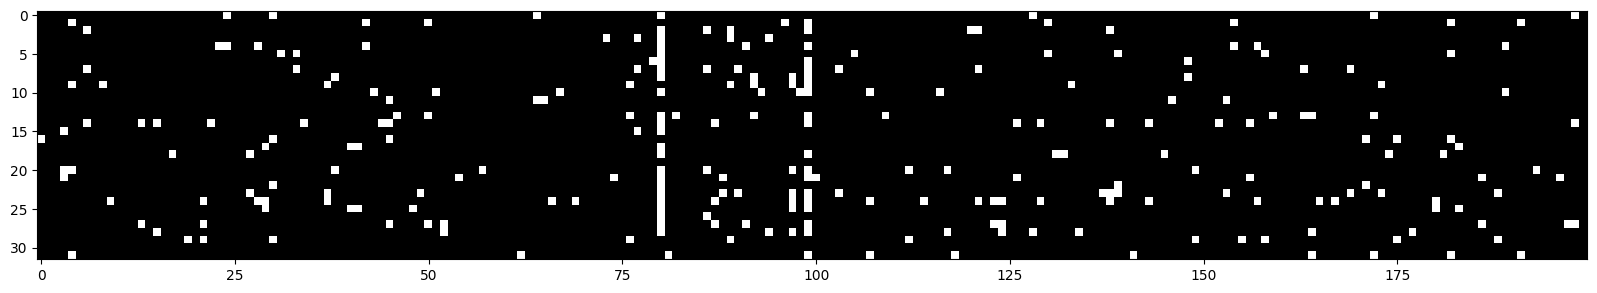

In [24]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray')

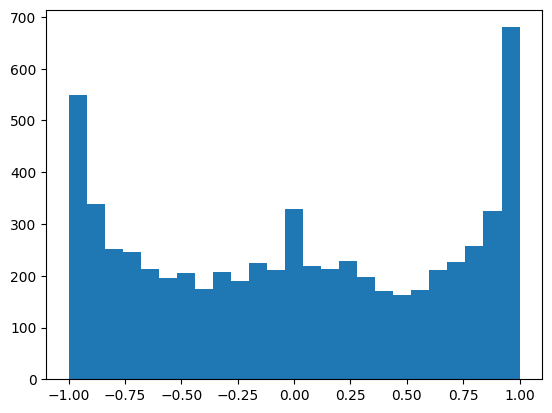

In [25]:
plt.hist(h.view(-1).tolist(), 25);

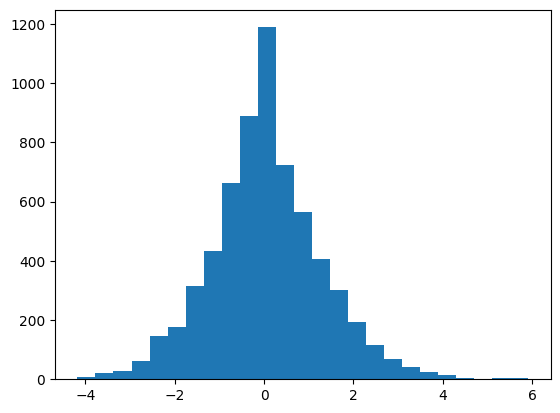

In [26]:
plt.hist(h_preact.view(-1).tolist(), 25);

In [27]:
@torch.no_grad()
def evaluate(evaluation_set):

    (Xc, Yc) = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[evaluation_set]

    embs = C[Xc]
    embs_resized = embs.view(embs.size()[0], -1)

    h_preact = embs_resized @ W1 + b1
    h_preact = bngain * (h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True) + bnshift

    h = h_preact.tanh()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yc)
    return loss

evaluate('test')


tensor(2.1737)

x: x.mean()=tensor(-0.0136), x.std()=tensor(0.9984)
y: y.mean()=tensor(0.0004), y.std()=tensor(0.9894)


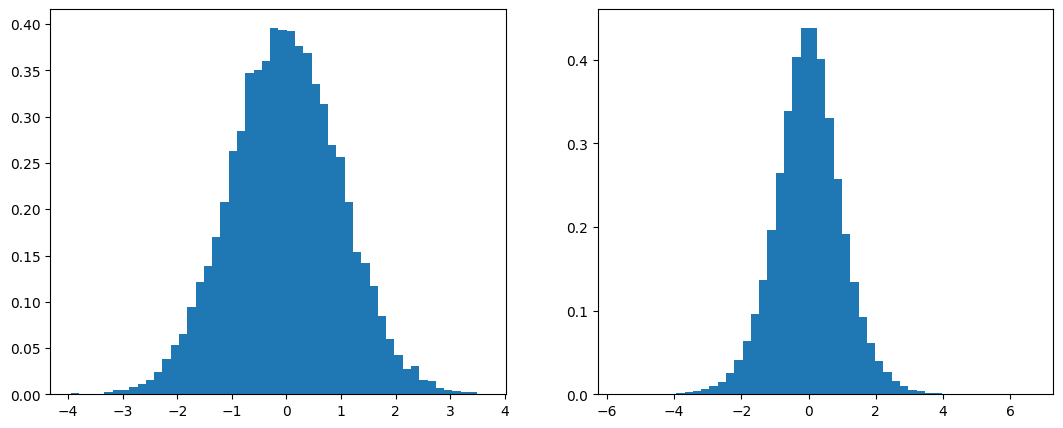

In [28]:
# Example on the exploding variance problem

x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # There is somekind of gain for each activation
z = torch.randn(200, 400)
y = x @ w

print(f"x: {x.mean()=}, {x.std()=}")
print(f"y: {y.mean()=}, {y.std()=}")

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.hist(x.view(-1), 50, density=True);
plt.subplot(132)
plt.hist(y.view(-1), 50, density=True);